# Cálculo de la SaO2 a partir de los datos crudos del sensor

## 1. Promedio de las señales (mean_ir y mean_red)
Primero, se calculan los promedios de las señales IR y RED para "centrarlas". Esto significa que eliminamos cualquier tendencia constante o baja frecuencia que pueda estar presente en las señales. Básicamente, queremos quedarnos solo con las variaciones de las señales.

## 2. Señales AC (Alternas)
Luego, restamos el valor promedio de cada señal para obtener las señales AC (alternas). Estas son las fluctuaciones de la señal que realmente nos interesan, ya que son las que están relacionadas con el pulso y la oxigenación sanguínea.

## 3. Raíz Cuadrada Media (RMS)
Calculamos la Raíz Cuadrada Media (RMS) de las señales AC de IR y RED. La RMS nos da una medida de la amplitud de la señal, es decir, de la "fuerza" de las variaciones en las señales.

La fórmula para calcular la RMS es: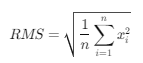

Donde x_i son los valores de la señal (en este caso, ir_ac o red_ac) y n es el número de muestras.
En otras palabras, estamos calculando cuánto varían las señales IR y RED con respecto a su valor promedio.
## 4. Cálculo del Ratio
El ratio es una medida que compara la variación de la señal RED con la de la señal IR. Este ratio es la base para estimar el SpO2, porque está relacionado con cómo absorbe la luz el hemoglobina en sangre.

El ratio se calcula así: ratio = (rms_red_ac / mean_red) / (rms_ir_ac / mean_ir)

Este ratio es importante porque las señales RED y IR son absorbidas de manera diferente por la hemoglobina oxigenada y desoxigenada. El SpO2 se calcula usando esta diferencia en la absorción de luz.

## 5. Cálculo de SpO₂
Con el ratio calculado, usamos una fórmula empírica que ha sido derivada de estudios previos para estimar el SpO₂ a partir de este ratio.

spo2 = -45.060 * (ratio ** 2) + 30.354 * ratio + 94.845 (codigo de pablo)

Esta fórmula es un modelo basado en la relación entre el ratio de las señales RED y IR y el SpO₂ en un pulsioxímetro.

Notas sobre la fórmula:

- Si el ratio es más bajo, el SpO₂ será más bajo (menos oxígeno en la sangre).

- Si el ratio es más alto, el SpO₂ será más alto (más oxígeno en la sangre).

## 6. Ajuste del SpO₂
Por último, se asegura que el valor de SpO₂ esté dentro de un rango válido (0 a 100). Si el cálculo da un valor fuera de este rango, se ajusta para mantenerlo dentro de los límites.

Este paso es importante porque, en situaciones en las que la señal es ruidosa o el cálculo no es preciso, el resultado no debería ser mayor de 100 ni menor de 0.

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

In [1]:
# Tabla de lookup para SpO2 --> obtenida del firmware original, se desconoce con qué está calibrada
uch_spo2_table = [95, 95, 95, 96, 96, 96, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 99, 99, 99, 99,
                                     99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
                                     100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 99, 99, 98, 98, 98, 98, 98, 98, 97, 97,
                                     97, 97, 96, 96, 96, 96, 95, 95, 95, 94, 94, 94, 93, 93, 93, 92, 92, 92, 91, 91,
                                     90, 90, 89, 89, 89, 88, 88, 87, 87, 86, 86, 85, 85, 84, 84, 83, 82, 82, 81, 81,
                                     80, 80, 79, 78, 78, 77, 76, 76, 75, 74, 74, 73, 72, 72, 71, 70, 69, 69, 68, 67,
                                     66, 66, 65, 64, 63, 62, 62, 61, 60, 59, 58, 57, 56, 56, 55, 54, 53, 52, 51, 50,
                                     49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 31, 30, 29,
                                     28, 27, 26, 25, 23, 22, 21, 20, 19, 17, 16, 15, 14, 12, 11, 10, 9, 7, 6, 5,
                                     3, 2, 1]

def maxim_find_peaks(data, min_height, min_distance):
    """Encuentra picos en una señal"""
    peaks = []
    length = len(data)
    i = 1
    while i < length - 1:
        if data[i] > min_height and data[i] > data[i - 1] and data[i] > data[i + 1]:
            peak_found = True
            for j in range(1, min_distance):
                if (i - j >= 0 and data[i] <= data[i - j]) or (i + j < length and data[i] <= data[i + j]):
                    peak_found = False
                    break
            if peak_found:
                peaks.append(i)
                i += min_distance  # Saltar distancia mínima
                continue
        i += 1
    return np.array(peaks)

def maxim_sort_indices_descending(values, indices):
    """Ordena los índices por el valor correspondiente (de mayor a menor)"""
    sorted_pairs = sorted(zip(values, indices), reverse=True)
    sorted_indices = [index for value, index in sorted_pairs]
    return np.array(sorted_indices)

def maxim_heart_rate_and_oxygen_saturation(ir_data, red_data, fs=100):
    """Traducción del algoritmo original C de estimación de HR y SpO2"""
    buffer_length = len(ir_data)
    if buffer_length < 100:
        raise ValueError("Se necesitan al menos 100 muestras para calcular")

    # 1. Remover la media de la señal IR
    ir_mean = np.mean(ir_data)
    ir_ac = ir_data - ir_mean

    # 2. Buscar picos (correspondientes a latidos)
    peak_indices = maxim_find_peaks(ir_ac, min_height=1000, min_distance=int(fs * 0.4))  # cada 0.4s 150 BPM
    num_peaks = len(peak_indices)

    heart_rate_valid = False
    spo2_valid = False
    spo2 = -999
    heart_rate = -999

    # 3. Calcular HR
    if num_peaks >= 2:
        peak_intervals = np.diff(peak_indices)
        peak_interval_mean = np.mean(peak_intervals)
        heart_rate = (fs * 60) / peak_interval_mean
        heart_rate_valid = True

    # 4. Calcular SpO2 basado en relación AC/DC
    ratios = []
    for i in range(num_peaks):
        idx = peak_indices[i]
        if idx + 4 >= buffer_length or idx - 4 < 0:
            continue
        ir_ac = ir_data[idx] - ir_mean
        ir_dc = np.mean(ir_data[idx - 4:idx + 5])
        red_ac = red_data[idx] - np.mean(red_data)
        red_dc = np.mean(red_data[idx - 4:idx + 5])

        if ir_dc > 0 and red_dc > 0:
            ratio = (red_ac / red_dc) / (ir_ac / ir_dc)
            ratios.append(ratio)

    # 5. Usar tabla de lookup
    if len(ratios) > 0:
        avg_ratio = np.mean(ratios)
        ratio_index = int(avg_ratio * 100)
        if 0 <= ratio_index < len(uch_spo2_table):
            spo2 = uch_spo2_table[ratio_index]
            spo2_valid = True

    return int(heart_rate), heart_rate_valid, int(spo2), spo2_valid


In [2]:
import numpy as np
# Definimos la ruta
ruta = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios'

# Iteramos sobre todos los CSV
archivos = glob.glob(os.path.join(ruta, '*.csv'))

resultados = []

for archivo in archivos:
    df = pd.read_csv(archivo)

    ir = df["IR"].values
    red = df["RED"].values

    # Llamamos al algoritmo
    try:
        hr, hr_valid, spo2, spo2_valid = maxim_heart_rate_and_oxygen_saturation(ir, red)
    except Exception as e:
        print(f"Error en {os.path.basename(archivo)}: {e}")
        continue

    resultados.append({
        'archivo': os.path.basename(archivo),
        'HR': hr if hr_valid else 'No válido',
        'SpO2': spo2 if spo2_valid else 'No válido'
    })

# Mostramos los resultados en tabla
df_resultados = pd.DataFrame(resultados)
display(df_resultados)


,archivo,HR,SpO2
0,raw_data_91_91.csv,No válido,No válido
1,raw_data_92_76.csv,137,No válido
2,raw_data_93_100.csv,No válido,95
3,raw_data_95_77_2.csv,92,100
4,raw_data_95_80.csv,47,No válido
5,raw_data_95_81_papa.csv,55,99
6,raw_data_95_99.csv,27,35
7,raw_data_96_106.csv,No válido,100
8,raw_data_96_69.csv,No válido,No válido
9,raw_data_97_119.csv,30,100


In [3]:
import os
import pandas as pd
import numpy as np

# Función que calcula el SpO2
def maxim_sort(data):
    return np.sort(data)

def maxim_get_spo2(ir_data, red_data):
    ir_data = np.array(ir_data, dtype=np.float64)
    red_data = np.array(red_data, dtype=np.float64)

    mean_ir = np.mean(ir_data)
    mean_red = np.mean(red_data)

    ir_ac = ir_data - mean_ir
    red_ac = red_data - mean_red

    rms_ir_ac = np.sqrt(np.mean(ir_ac ** 2))
    rms_red_ac = np.sqrt(np.mean(red_ac ** 2))

    if mean_ir == 0 or mean_red == 0 or rms_ir_ac == 0:
        return -999, 0

    ratio = (rms_red_ac / mean_red) / (rms_ir_ac / mean_ir)

    spo2 = -45.060 * (ratio ** 2) + 30.354 * ratio + 94.845

    if spo2 > 100:
        spo2 = 100
    elif spo2 < 0:
        spo2 = 0

    valid = 1 if 0 < spo2 < 100 else 0

    return int(round(spo2)), valid

# Carpeta donde están los archivos CSV
folder_path = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Iterar sobre todos los archivos .csv en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)

        # Cargar el CSV
        data = pd.read_csv(file_path)

        # Asegurarnos de que las columnas necesarias están en el CSV
        if 'IR' in data.columns and 'RED' in data.columns:
            # Seleccionar las primeras 100 muestras
            ir_data = data['IR'][:100].values
            red_data = data['RED'][:100].values

            # Calcular SpO2 para las primeras 100 muestras
            spo2, valid = maxim_get_spo2(ir_data, red_data)

            # Mostrar los resultados por pantalla
            print(f"Archivo: {file_name}")
            print(f"  SpO2: {spo2}%")
            print('-' * 40)


Archivo: raw_data_91_91.csv
  SpO2: 95%
----------------------------------------
Archivo: raw_data_92_76.csv
  SpO2: 95%
----------------------------------------
Archivo: raw_data_93_100.csv
  SpO2: 96%
----------------------------------------
Archivo: raw_data_95_77_2.csv
  SpO2: 97%
----------------------------------------
Archivo: raw_data_95_80.csv
  SpO2: 99%
----------------------------------------
Archivo: raw_data_95_81_papa.csv
  SpO2: 98%
----------------------------------------
Archivo: raw_data_95_99.csv
  SpO2: 98%
----------------------------------------
Archivo: raw_data_96_69.csv
  SpO2: 96%
----------------------------------------
Archivo: raw_data_96_81.csv
  SpO2: 99%
----------------------------------------
Archivo: raw_data_97_95.csv
  SpO2: 0%
----------------------------------------
Archivo: raw_data_98_81.csv
  SpO2: 96%
----------------------------------------
Archivo: raw_data_98_86.csv
  SpO2: 90%
----------------------------------------
Archivo: raw_data_99_

Archivo: raw_data_91_91.csv
  SpO2: 95%
----------------------------------------


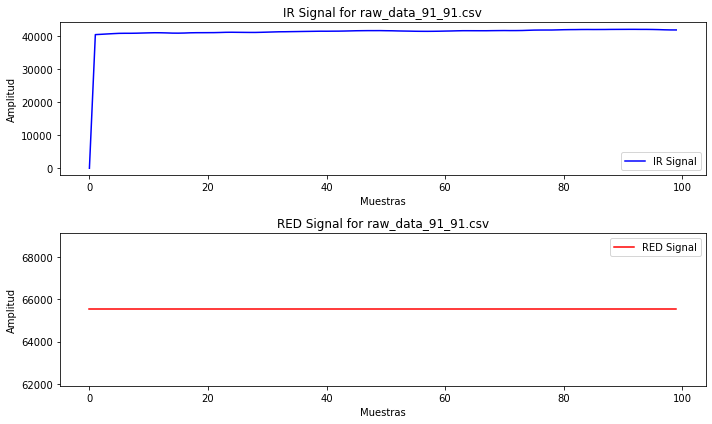

Archivo: raw_data_92_76.csv
  SpO2: 95%
----------------------------------------


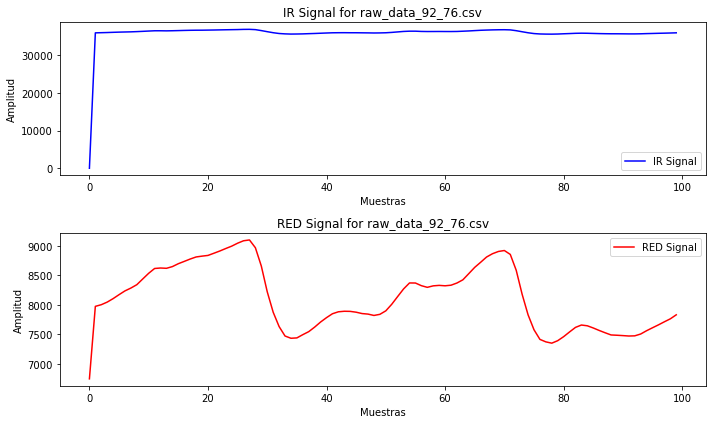

Archivo: raw_data_93_100.csv
  SpO2: 96%
----------------------------------------


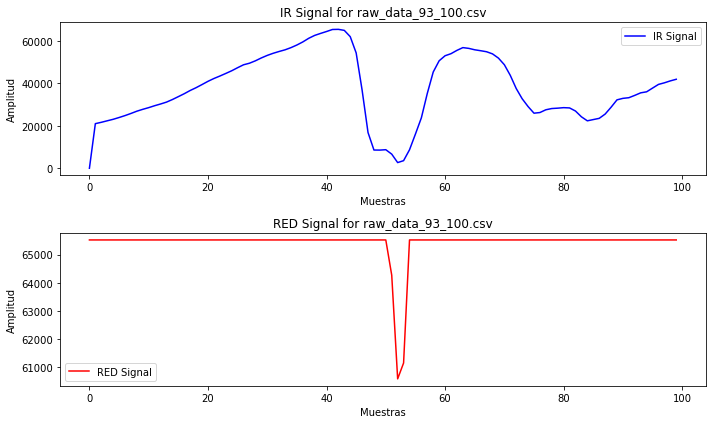

Archivo: raw_data_95_77_2.csv
  SpO2: 97%
----------------------------------------


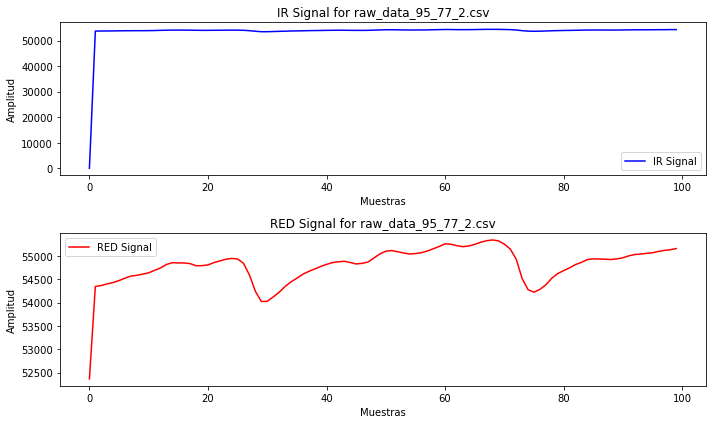

Archivo: raw_data_95_80.csv
  SpO2: 99%
----------------------------------------


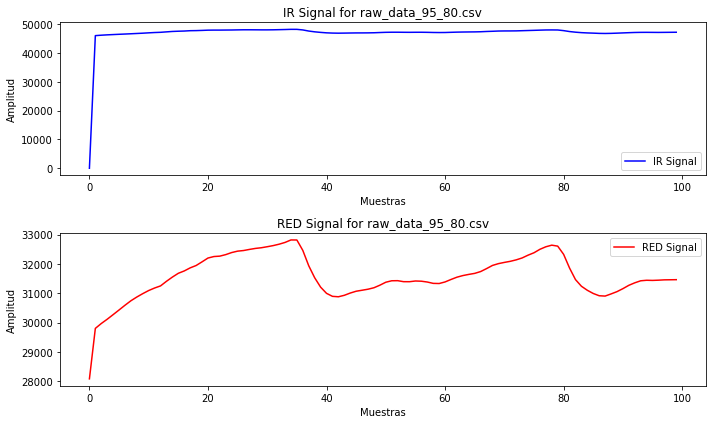

Archivo: raw_data_95_81_papa.csv
  SpO2: 98%
----------------------------------------


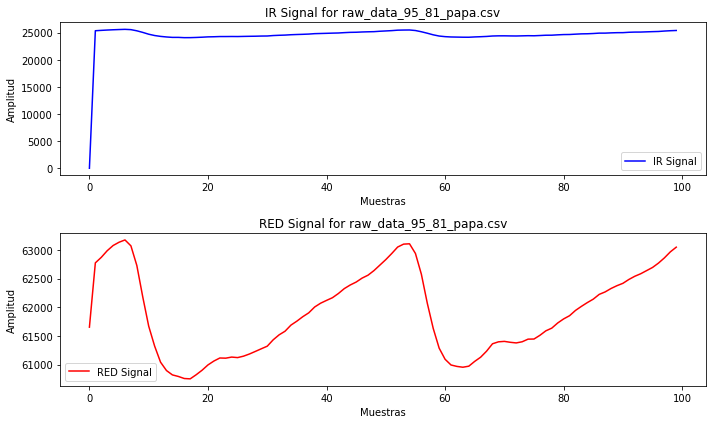

Archivo: raw_data_95_99.csv
  SpO2: 98%
----------------------------------------


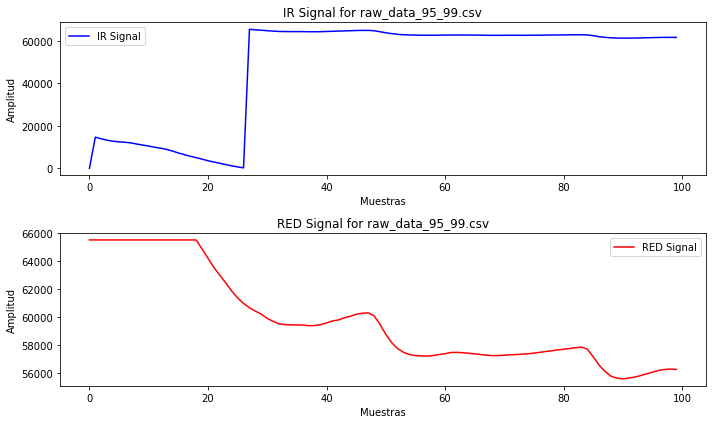

Archivo: raw_data_96_69.csv
  SpO2: 96%
----------------------------------------


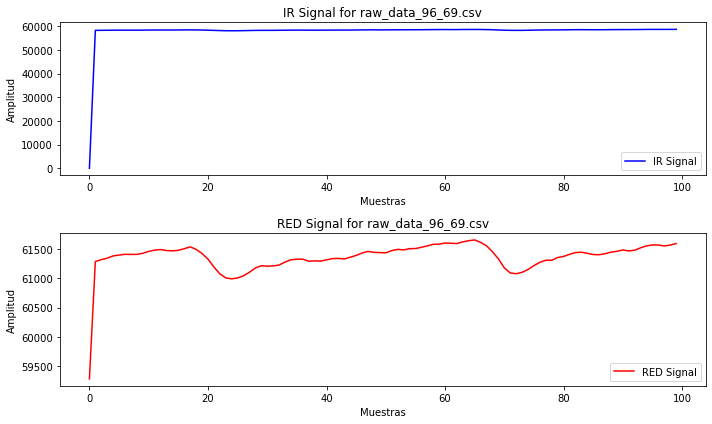

Archivo: raw_data_96_81.csv
  SpO2: 99%
----------------------------------------


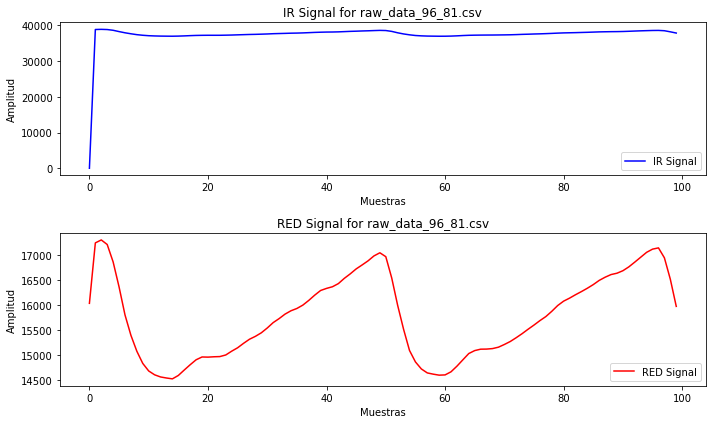

Archivo: raw_data_97_95.csv
  SpO2: 0%
----------------------------------------


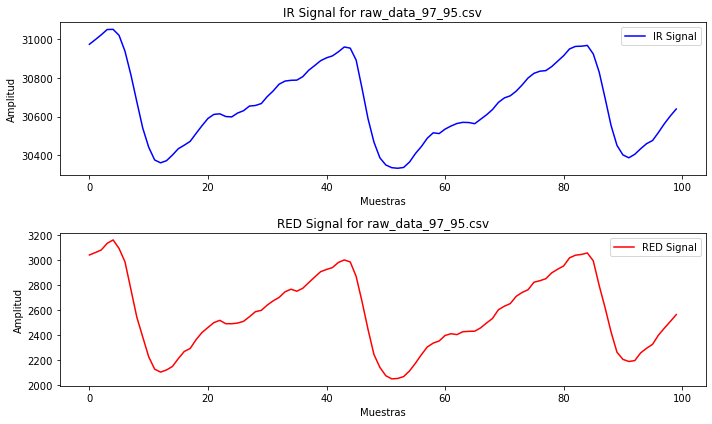

Archivo: raw_data_98_81.csv
  SpO2: 96%
----------------------------------------


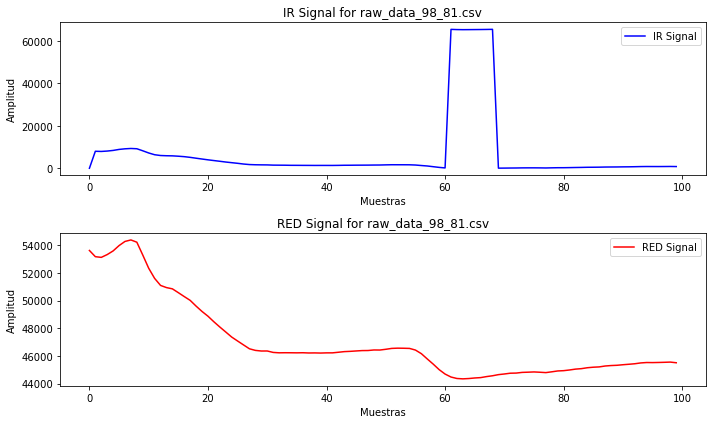

Archivo: raw_data_98_86.csv
  SpO2: 90%
----------------------------------------


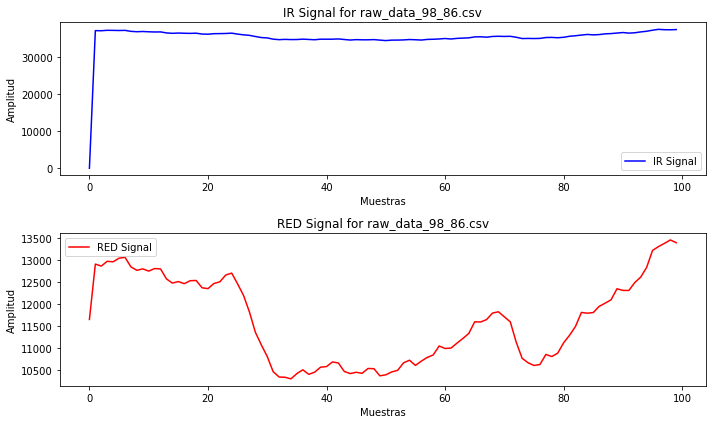

Archivo: raw_data_99_73.csv
  SpO2: 95%
----------------------------------------


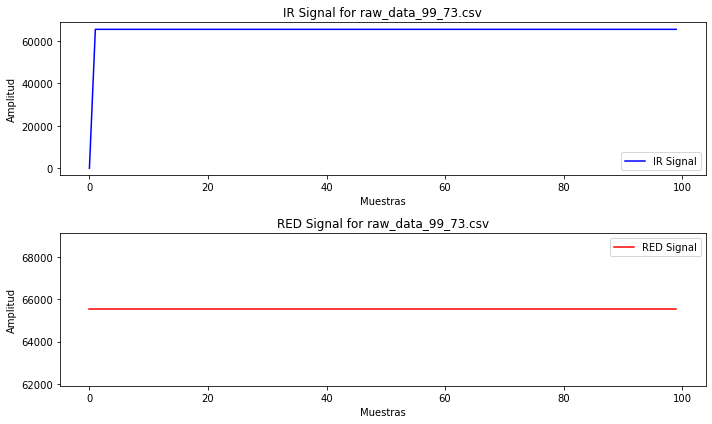

Archivo: raw_data_99_75.csv
  SpO2: 97%
----------------------------------------


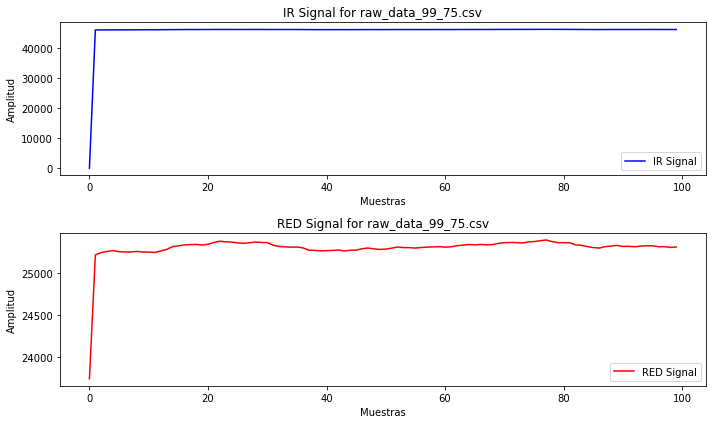

Archivo: raw_data_99_91.csv
  SpO2: 95%
----------------------------------------


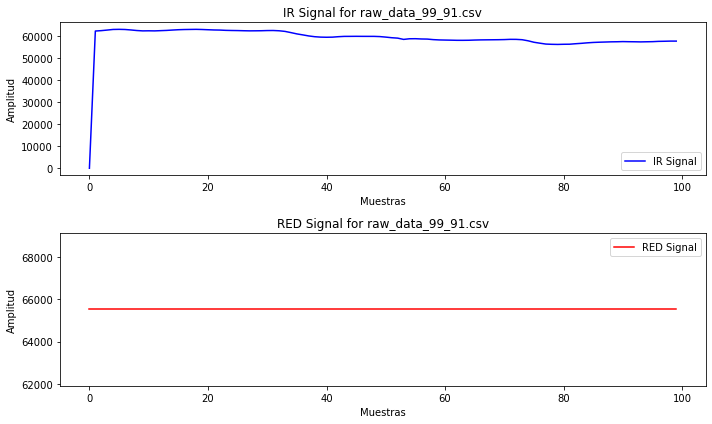

In [4]:
import os
import pandas as pd
import numpy as np

# Función que calcula el SpO2
def maxim_sort(data):
    return np.sort(data)

def maxim_get_spo2(ir_data, red_data):
    ir_data = np.array(ir_data, dtype=np.float64)
    red_data = np.array(red_data, dtype=np.float64)

    mean_ir = np.mean(ir_data)
    mean_red = np.mean(red_data)

    ir_ac = ir_data - mean_ir
    red_ac = red_data - mean_red

    rms_ir_ac = np.sqrt(np.mean(ir_ac ** 2))
    rms_red_ac = np.sqrt(np.mean(red_ac ** 2))

    if mean_ir == 0 or mean_red == 0 or rms_ir_ac == 0:
        return -999, 0

    ratio = (rms_red_ac / mean_red) / (rms_ir_ac / mean_ir)

    spo2 = -45.060 * (ratio ** 2) + 30.354 * ratio + 94.845

    if spo2 > 100:
        spo2 = 100
    elif spo2 < 0:
        spo2 = 0

    valid = 1 if 0 < spo2 < 100 else 0

    return int(round(spo2)), valid

# Carpeta donde están los archivos CSV
folder_path = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Iterar sobre todos los archivos .csv en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)

        # Cargar el CSV
        data = pd.read_csv(file_path)

        # Asegurarnos de que las columnas necesarias están en el CSV
        if 'IR' in data.columns and 'RED' in data.columns:
            # Seleccionar las primeras 100 muestras
            ir_data = data['IR'][:100].values
            red_data = data['RED'][:100].values

            # Calcular SpO2 para las primeras 100 muestras
            spo2, valid = maxim_get_spo2(ir_data, red_data)

            # Mostrar los resultados por pantalla
            print(f"Archivo: {file_name}")
            print(f"  SpO2: {spo2}%")
            print('-' * 40)
            # Graficar las señales IR y RED
            plt.figure(figsize=(10, 6))
            plt.subplot(2, 1, 1)
            plt.plot(ir_data, label='IR Signal', color='blue')
            plt.title(f'IR Signal for {file_name}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            plt.subplot(2, 1, 2)
            plt.plot(red_data, label='RED Signal', color='red')
            plt.title(f'RED Signal for {file_name}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            # Mostrar la gráfica
            plt.tight_layout()
            plt.show()


raw_data_91_91.csv → Real: 91%, Estimada: 95%
raw_data_92_76.csv → Real: 92%, Estimada: 95%
raw_data_93_100.csv → Real: 93%, Estimada: 96%
raw_data_95_77_2.csv → Real: 95%, Estimada: 97%
raw_data_95_80.csv → Real: 95%, Estimada: 99%
raw_data_95_81_papa.csv → Real: 95%, Estimada: 98%
raw_data_95_99.csv → Real: 95%, Estimada: 98%
raw_data_96_69.csv → Real: 96%, Estimada: 96%
raw_data_96_81.csv → Real: 96%, Estimada: 99%
raw_data_97_95.csv → Señal no válida
raw_data_98_81.csv → Real: 98%, Estimada: 96%
raw_data_98_86.csv → Real: 98%, Estimada: 90%
raw_data_99_73.csv → Real: 99%, Estimada: 95%
raw_data_99_75.csv → Real: 99%, Estimada: 97%
raw_data_99_91.csv → Real: 99%, Estimada: 95%


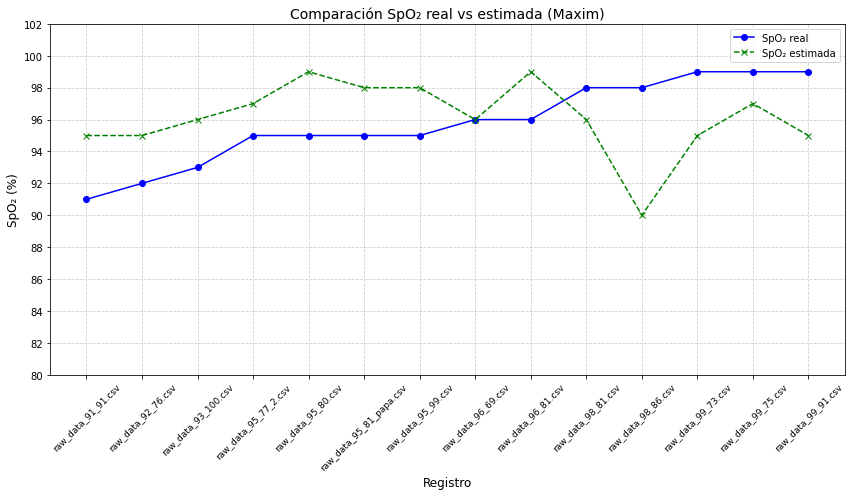

Gráfico guardado en: C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\SpO2\grafico_spo_algo_v4.png


<Figure size 432x288 with 0 Axes>

In [5]:

import matplotlib.pyplot as plt

# Función SpO2
def maxim_get_spo2(ir_data, red_data):
    ir_data = np.array(ir_data, dtype=np.float64)
    red_data = np.array(red_data, dtype=np.float64)
    mean_ir = np.mean(ir_data)
    mean_red = np.mean(red_data)
    ir_ac = ir_data - mean_ir
    red_ac = red_data - mean_red
    rms_ir_ac = np.sqrt(np.mean(ir_ac ** 2))
    rms_red_ac = np.sqrt(np.mean(red_ac ** 2))
    if mean_ir == 0 or mean_red == 0 or rms_ir_ac == 0:
        return -999, 0
    ratio = (rms_red_ac / mean_red) / (rms_ir_ac / mean_ir)
    spo2 = -45.060 * (ratio ** 2) + 30.354 * ratio + 94.845
    spo2 = min(100, max(0, spo2))
    valid = 1 if 0 < spo2 < 100 else 0
    return int(round(spo2)), valid

# Ruta a tus archivos
folder_path = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2'

# Inicializar listas
real_values = []
estimadas = []
nombres = []

# Bucle de lectura
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name.startswith("raw_data_"):
        partes = file_name.replace(".csv", "").split("_")
        if len(partes) >= 3:
            try:
                spo2_real = int(partes[2])  # tercer campo del nombre = SpO2 real
                file_path = os.path.join(folder_path, file_name)
                data = pd.read_csv(file_path)

                if 'IR' in data.columns and 'RED' in data.columns:
                    ir_data = data['IR'][:100].values
                    red_data = data['RED'][:100].values
                    spo2_estimada, valid = maxim_get_spo2(ir_data, red_data)

                    if valid:
                        real_values.append(spo2_real)
                        estimadas.append(spo2_estimada)
                        nombres.append(file_name)
                        print(f"{file_name} → Real: {spo2_real}%, Estimada: {spo2_estimada}%")
                    else:
                        print(f"{file_name} → Señal no válida")
            except Exception as e:
                print(f"{file_name} → ERROR: {e}")

# Graficar comparación final con escala mejorada
if real_values and estimadas:
    indices = range(1, len(real_values) + 1)
    errores = np.array(estimadas) - np.array(real_values)

    plt.figure(figsize=(12, 7))  # más alto para dar aire visual
    plt.plot(indices, real_values, label="SpO₂ real", marker='o', linestyle='-', color='blue')
    plt.plot(indices, estimadas, label="SpO₂ estimada", marker='x', linestyle='--', color='green')

    plt.title("Comparación SpO₂ real vs estimada (Maxim)", fontsize=14)
    plt.xlabel("Registro", fontsize=12)
    plt.ylabel("SpO₂ (%)", fontsize=12)
    plt.xticks(indices, nombres, rotation=45, fontsize=9)  # etiquetas con nombres de archivo
    plt.yticks(np.arange(80, 105, 2))  # escala más detallada en Y
    plt.ylim(80, 102)  # forzar margen superior e inferior
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Guardar en PNG
    ruta_salida = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\SpO2\grafico_spo_algo_v4.png"
    plt.savefig(ruta_salida)
    print(f"Gráfico guardado en: {ruta_salida}")

    plt.show()



Archivo: raw_data_91_91.csv
  SpO2: 95%
----------------------------------------


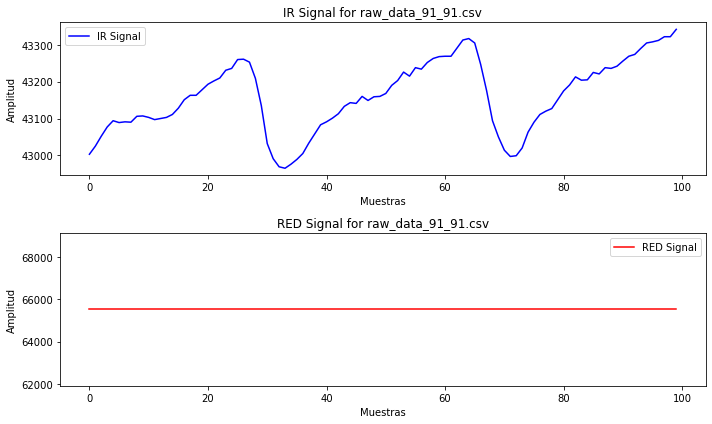

Archivo: raw_data_92_76.csv
  SpO2: 0%
----------------------------------------


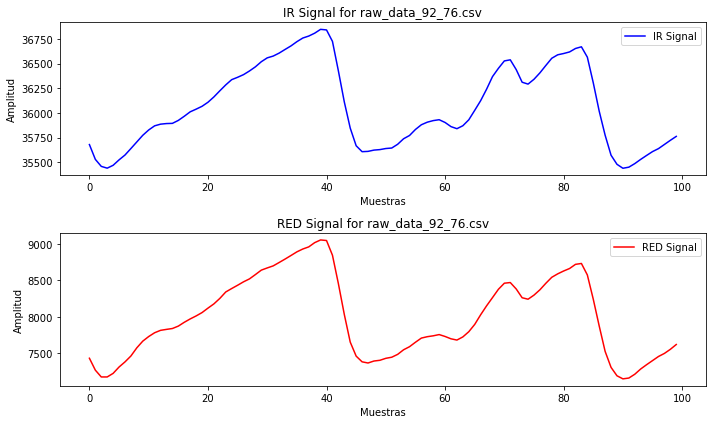

Archivo: raw_data_93_100.csv
  SpO2: 95%
----------------------------------------


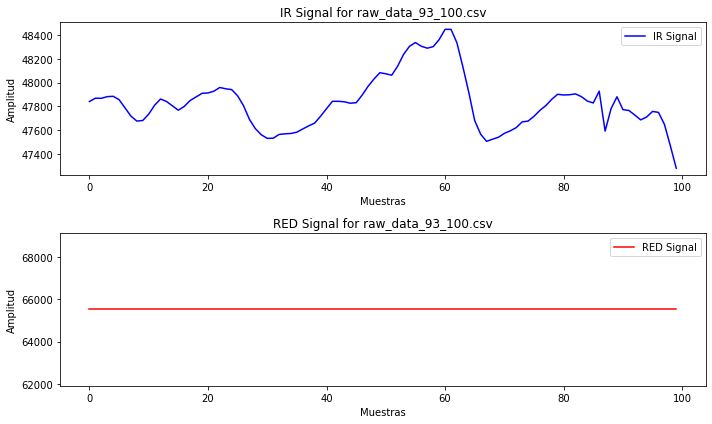

Archivo: raw_data_95_77_2.csv
  SpO2: 41%
----------------------------------------


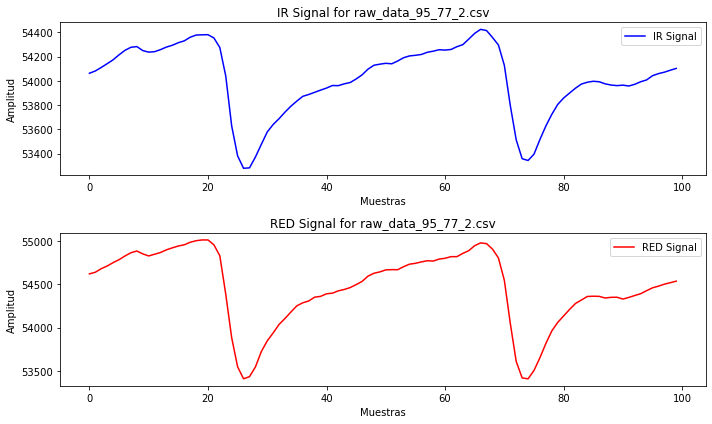

Archivo: raw_data_95_80.csv
  SpO2: 0%
----------------------------------------


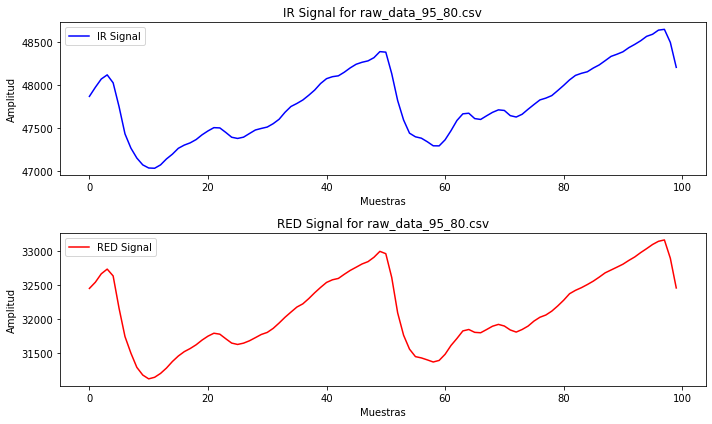

Archivo: raw_data_95_81_papa.csv
  SpO2: 96%
----------------------------------------


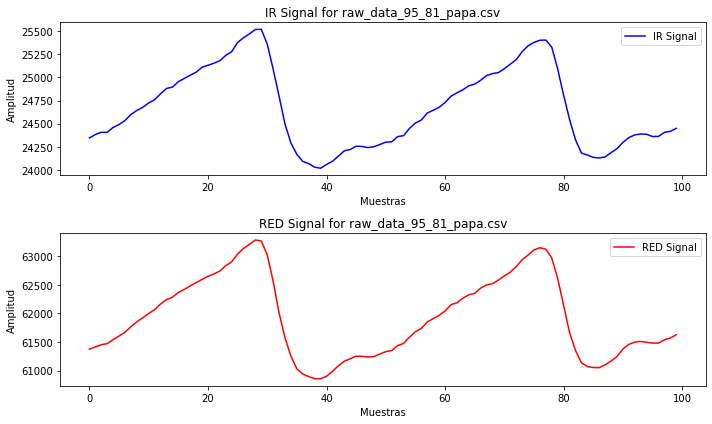

Archivo: raw_data_95_99.csv
  SpO2: 47%
----------------------------------------


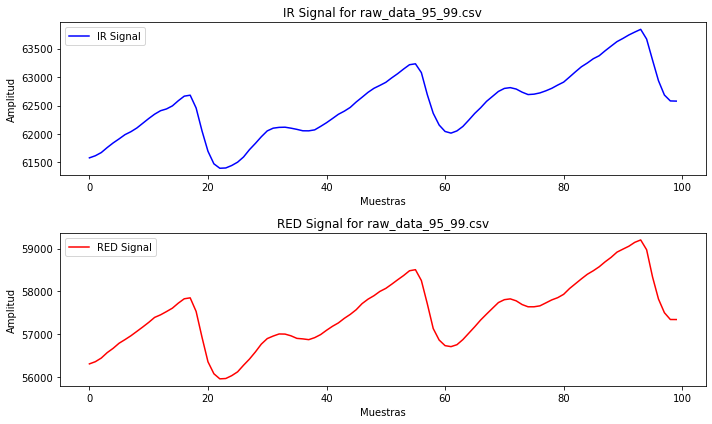

Archivo: raw_data_96_106.csv
  SpO2: 81%
----------------------------------------


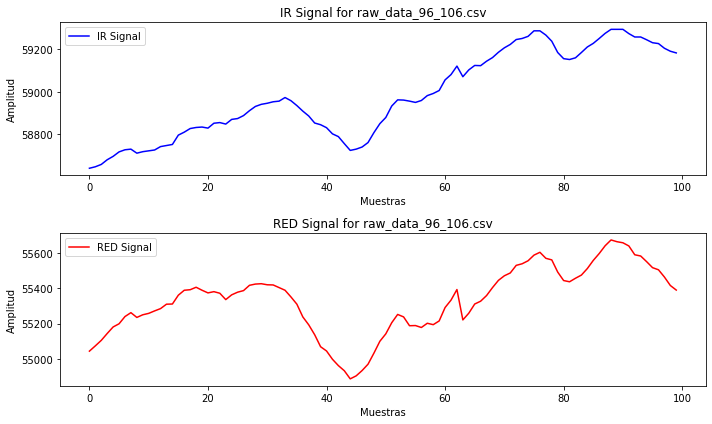

Archivo: raw_data_96_69.csv
  SpO2: 78%
----------------------------------------


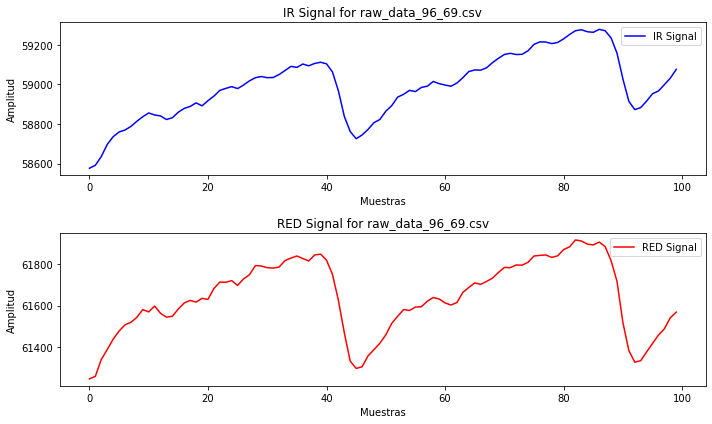

Archivo: raw_data_97_119.csv
  SpO2: 73%
----------------------------------------


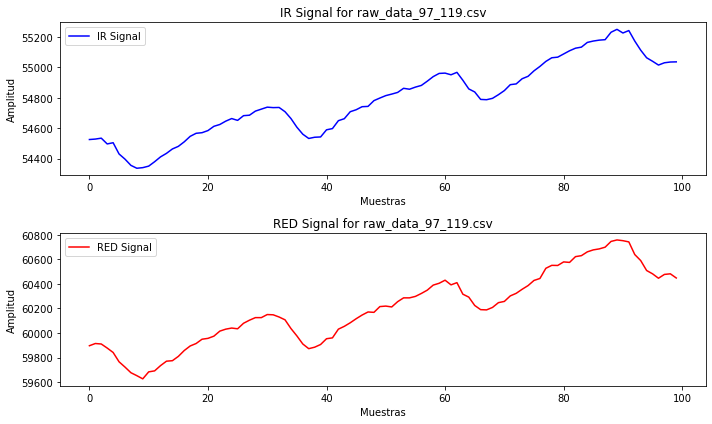

Archivo: raw_data_97_95.csv
  SpO2: 0%
----------------------------------------


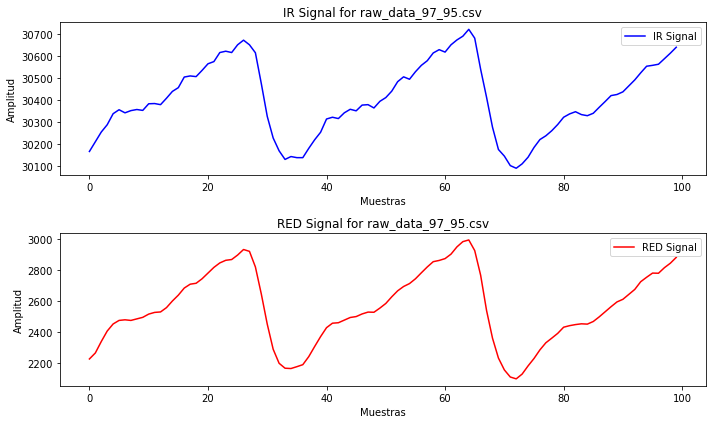

Archivo: raw_data_98_81.csv
  SpO2: 0%
----------------------------------------


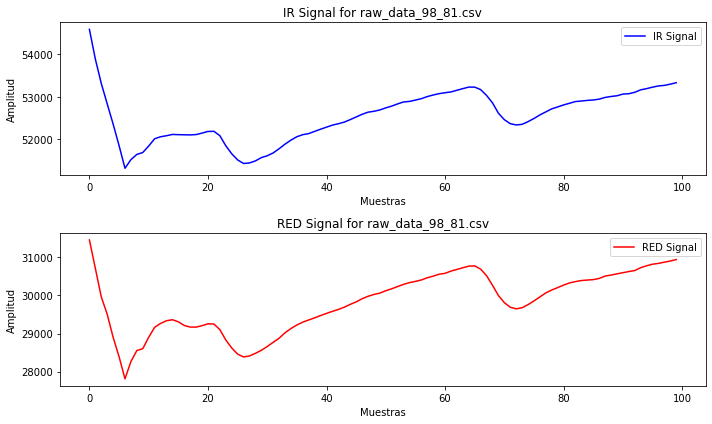

Archivo: raw_data_98_86.csv
  SpO2: 0%
----------------------------------------


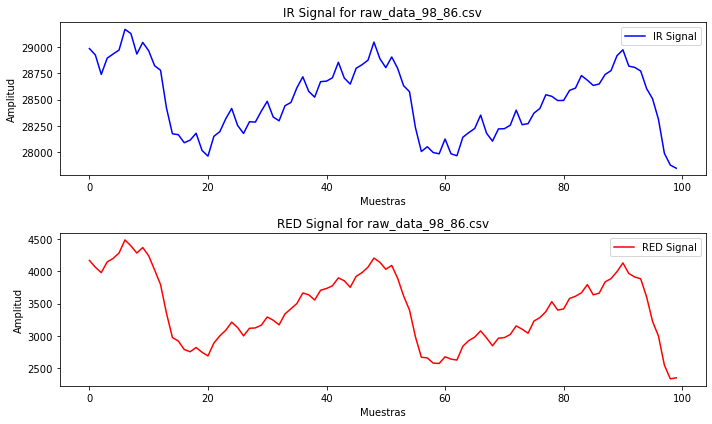

Archivo: raw_data_98_91.csv
  SpO2: 61%
----------------------------------------


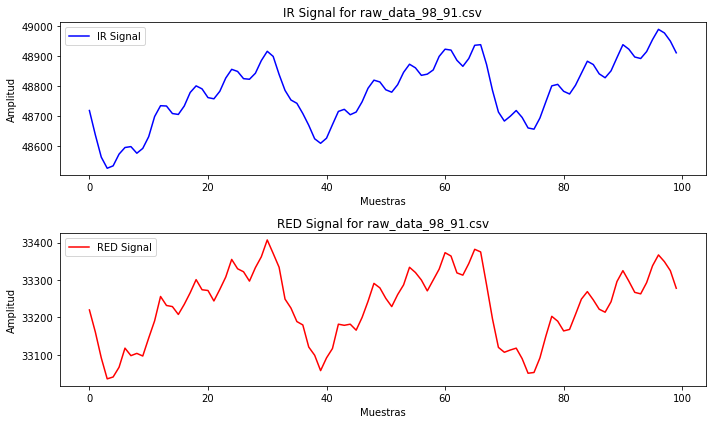

Archivo: raw_data_99_75.csv
  SpO2: 0%
----------------------------------------


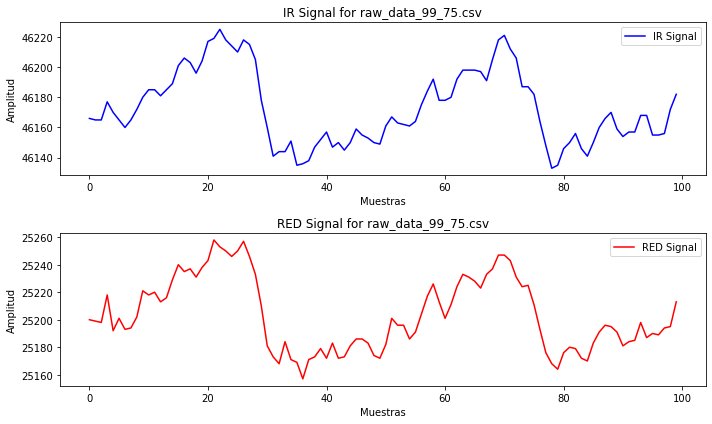

Archivo: raw_data_99_91.csv
  SpO2: 95%
----------------------------------------


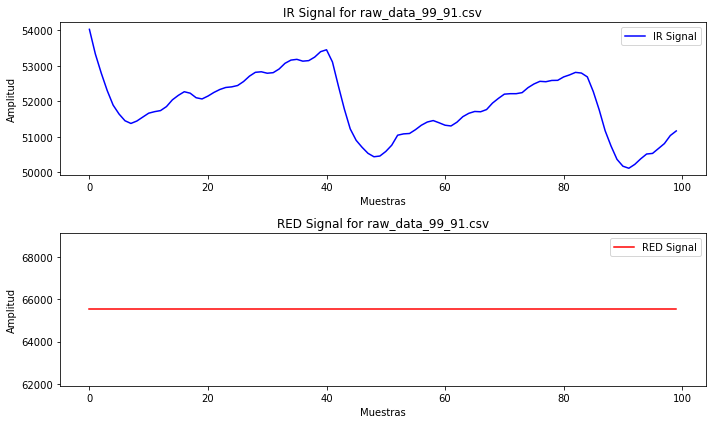

In [7]:
import os
import pandas as pd
import numpy as np

# Función que calcula el SpO2
def maxim_sort(data):
    return np.sort(data)

def maxim_get_spo2(ir_data, red_data):
    ir_data = np.array(ir_data, dtype=np.float64)
    red_data = np.array(red_data, dtype=np.float64)

    mean_ir = np.mean(ir_data)
    mean_red = np.mean(red_data)

    ir_ac = ir_data - mean_ir
    red_ac = red_data - mean_red

    rms_ir_ac = np.sqrt(np.mean(ir_ac ** 2))
    rms_red_ac = np.sqrt(np.mean(red_ac ** 2))

    if mean_ir == 0 or mean_red == 0 or rms_ir_ac == 0:
        return -999, 0

    ratio = (rms_red_ac / mean_red) / (rms_ir_ac / mean_ir)

    spo2 = -45.060 * (ratio ** 2) + 30.354 * ratio + 94.845

    if spo2 > 100:
        spo2 = 100
    elif spo2 < 0:
        spo2 = 0

    valid = 1 if 0 < spo2 < 100 else 0

    return int(round(spo2)), valid

# Carpeta donde están los archivos CSV
folder_path = r'C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios'

# Iterar sobre todos los archivos .csv en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)

        # Cargar el CSV
        data = pd.read_csv(file_path)

        # Asegurarnos de que las columnas necesarias están en el CSV
        if 'IR' in data.columns and 'RED' in data.columns:
            # Seleccionar las primeras 100 muestras
            ir_data = data['IR'][:100].values
            red_data = data['RED'][:100].values

            # Calcular SpO2 para las primeras 100 muestras
            spo2, valid = maxim_get_spo2(ir_data, red_data)

            # Mostrar los resultados por pantalla
            print(f"Archivo: {file_name}")
            print(f"  SpO2: {spo2}%")
            print('-' * 40)
            # Graficar las señales IR y RED
            plt.figure(figsize=(10, 6))
            plt.subplot(2, 1, 1)
            plt.plot(ir_data, label='IR Signal', color='blue')
            plt.title(f'IR Signal for {file_name}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            plt.subplot(2, 1, 2)
            plt.plot(red_data, label='RED Signal', color='red')
            plt.title(f'RED Signal for {file_name}')
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend()

            # Mostrar la gráfica
            plt.tight_layout()
            plt.show()
